In [1]:
# import numpy as np, matplotlib.pyplot as plt
# from pathlib import Path

# def beta_scaled(rng, shape, a, b, lo, hi):
#     z = rng.beta(a, b, size=shape)
#     return lo + z*(hi-lo)

# def sample_instance(rng, scenario, S=10, G=10, D=10, lo=1.0, hi=100.0, tau=1.0, eps=0.10):
#     probs = rng.dirichlet(np.ones(S)*tau)
#     mc = rng.uniform(lo, hi, size=G)
#     mv = rng.uniform(lo, hi, size=D)
#     is_tail = np.zeros(S, dtype=bool)

#     if scenario=="s_1":
#         g = rng.uniform(lo, hi, size=(S,G))
#         d = rng.uniform(lo, hi, size=(S,D))

#     elif scenario=="s_2":
#         g = beta_scaled(rng, (S,G), 0.4, 4.0, lo, hi)
#         d = rng.uniform(lo, hi, size=(S,D))

#     elif scenario=="s_3":
#         g = rng.uniform(lo, hi, size=(S,G))
#         d = beta_scaled(rng, (S,D), 4.0, 0.4, lo, hi)

#     elif scenario=="s_4":
#         g = beta_scaled(rng, (S,G), 0.8, 3.0, lo, hi)
#         d = beta_scaled(rng, (S,D), 3.0, 0.8, lo, hi)
#         is_tail = rng.random(S) < eps
#         shrink = rng.uniform(0.05, 0.30, size=(S,1))
#         blow   = rng.uniform(1.20, 1.80, size=(S,1))
#         g = np.where(is_tail[:,None], g*shrink, g)
#         d = np.where(is_tail[:,None], d*blow, d)
#         g = np.clip(g, lo, hi); d = np.clip(d, lo, hi)

#     elif scenario=="s_5":
#         probs = rng.dirichlet(np.ones(S)*tau)
#         mc = rng.uniform(lo, hi, size=G)
#         mv = rng.uniform(lo, hi, size=D)
#         inter = rng.random(G) < 0.30
#         a_g = np.where(inter, 0.5, 3.0); b_g = np.where(inter, 4.0, 3.0)
#         g = lo + rng.beta(a_g, b_g, size=(S,G))*(hi-lo)
#         d = beta_scaled(rng, (S,D), 3.0, 3.0, lo, hi)

#     else:
#         raise ValueError("unknown scenario")
#     return probs, mc, mv, g, d, {"is_tail":is_tail}

# def plot_probs(probs, title, out):
#     plt.figure(figsize=(6,3)); plt.bar(np.arange(len(probs)), probs); plt.title(title); plt.xlabel("scenario"); plt.ylabel("prob"); plt.tight_layout(); plt.savefig(out); plt.show()

# def plot_hist(x, title, out, bins=40):
#     plt.figure(figsize=(6,3)); plt.hist(x.ravel(), bins=bins); plt.title(title); plt.xlabel("value"); plt.ylabel("freq"); plt.tight_layout(); plt.savefig(out); plt.show()

# def plot_supply_demand_scatter(g, d, title, out, is_tail=None):
#     gsum = g.sum(1); dsum = d.sum(1)
#     plt.figure(figsize=(4,4))
#     if is_tail is None or is_tail.sum()==0:
#         plt.scatter(gsum, dsum)
#     else:
#         idx0 = ~is_tail; idx1 = is_tail
#         plt.scatter(gsum[idx0], dsum[idx0], label="normal")
#         plt.scatter(gsum[idx1], dsum[idx1], marker="x", label="stress")
#         plt.legend()
#     plt.title(title); plt.xlabel("total supply cap"); plt.ylabel("total demand cap"); plt.tight_layout(); plt.savefig(out); plt.show()

# def visualize_scenario(rng, scenario, S=10, G=10, D=10, lo=1.0, hi=100.0, tau=1.0, eps=0.10, outdir=Path("figures")):
#     outdir.mkdir(parents=True, exist_ok=True)
#     probs, mc, mv, g, d, extras = sample_instance(rng, scenario, S,G,D,lo,hi,tau,eps)
#     tag = f"{scenario}_S{S}_G{G}_D{D}"
#     plot_probs(probs, f"{scenario}: scenario probabilities", outdir/f"{tag}_probs.png")
#     plot_hist(g, f"{scenario}: generator caps", outdir/f"{tag}_g_hist.png")
#     plot_hist(d, f"{scenario}: demand caps", outdir/f"{tag}_d_hist.png")
#     plot_supply_demand_scatter(g, d, f"{scenario}: per-scenario totals", outdir/f"{tag}_totals.png", extras.get("is_tail"))

# if __name__=="__main__":
#     rng = np.random.default_rng(123)
#     scenarios = ["s_1","s_2","s_3","s_4","s_5"]
#     for sc in scenarios:
#         visualize_scenario(rng, sc, S=30, G=20, D=20, lo=1.0, hi=100.0, tau=1.0, eps=0.10)

Helper Methods for generating instances

In [5]:
# --- add imports at top of notebook ---
import jax
import jax.numpy as jnp
from jax import random

# JAX version of beta_scaled
def beta_scaled_jax(key, shape, a, b, lo, hi):
    z = random.beta(key, a, b, shape=shape)
    return lo + z * (hi - lo)

# Your function, parameterized and JAX-pure
def generate_instance(key, scenario="s_1", S=10, G=10, D=10, lo=1.0, hi=100.0, tau=1.0, eps=0.10):
    if scenario == "s_1":
        probs_key, mc_key, mv_key, g_key, d_key = random.split(key, 5)
        probs = random.dirichlet(probs_key, jnp.ones(S) * tau)
        mc = random.uniform(mc_key, (G,), minval=lo, maxval=hi)
        mv = random.uniform(mv_key, (D,), minval=lo, maxval=hi)
        g  = random.uniform(g_key, (S, G), minval=lo, maxval=hi)
        d  = random.uniform(d_key, (S, D), minval=lo, maxval=hi)
        is_tail = jnp.zeros((S,), dtype=bool)

    elif scenario == "s_2":
        # Supply-shortage tails: gen caps left-heavy (more mass near lo)
        probs_key, mc_key, mv_key, g_key, d_key = random.split(key, 5)
        probs = random.dirichlet(probs_key, jnp.ones(S) * tau)
        mc = random.uniform(mc_key, (G,), minval=lo, maxval=hi)
        mv = random.uniform(mv_key, (D,), minval=lo, maxval=hi)
        g  = beta_scaled_jax(g_key, (S, G), a=0.4, b=4.0, lo=lo, hi=hi)
        d  = random.uniform(d_key, (S, D), minval=lo, maxval=hi)
        is_tail = jnp.zeros((S,), dtype=bool)

    elif scenario == "s_3":
        # Demand-surge tails: demand caps right-heavy (more mass near hi)
        probs_key, mc_key, mv_key, g_key, d_key = random.split(key, 5)
        probs = random.dirichlet(probs_key, jnp.ones(S) * tau)
        mc = random.uniform(mc_key, (G,), minval=lo, maxval=hi)
        mv = random.uniform(mv_key, (D,), minval=lo, maxval=hi)
        g  = random.uniform(g_key, (S, G), minval=lo, maxval=hi)
        d  = beta_scaled_jax(d_key, (S, D), a=4.0, b=0.4, lo=lo, hi=hi)
        is_tail = jnp.zeros((S,), dtype=bool)

    elif scenario == "s_4":
        # Correlated extremes: shrink gen & blow up demand in epsilon share
        probs_key, mc_key, mv_key, g0, d0, t_key, k_shrink, k_blow = random.split(key, 8)
        probs = random.dirichlet(probs_key, jnp.ones(S) * tau)
        mc = random.uniform(mc_key, (G,), minval=lo, maxval=hi)
        mv = random.uniform(mv_key, (D,), minval=lo, maxval=hi)
        g  = beta_scaled_jax(g0, (S, G), a=0.8, b=3.0, lo=lo, hi=hi)
        d  = beta_scaled_jax(d0, (S, D), a=3.0, b=0.8, lo=lo, hi=hi)
        is_tail = random.bernoulli(t_key, eps, (S,))
        shrink = random.uniform(k_shrink, (S, 1), minval=0.05, maxval=0.30)
        blow   = random.uniform(k_blow,   (S, 1), minval=1.20, maxval=1.80)
        g = jnp.where(is_tail[:, None], g * shrink, g)
        d = jnp.where(is_tail[:, None], d * blow,   d)
        g = jnp.clip(g, lo, hi); d = jnp.clip(d, lo, hi)

    elif scenario == "s_5":
        # Opposite stress: blow up gen & shrink demand in epsilon share
        probs_key, mc_key, mv_key, g0, d0, t_key, k_shrink, k_blow = random.split(key, 8)
        probs = random.dirichlet(probs_key, jnp.ones(S) * tau)
        mc = random.uniform(mc_key, (G,), minval=lo, maxval=hi)
        mv = random.uniform(mv_key, (D,), minval=lo, maxval=hi)
        g  = beta_scaled_jax(g0, (S, G), a=3.0, b=0.8, lo=lo, hi=hi)
        d  = beta_scaled_jax(d0, (S, D), a=0.8, b=3.0, lo=lo, hi=hi)
        is_tail = random.bernoulli(t_key, eps, (S,))
        shrink = random.uniform(k_shrink, (S, 1), minval=0.05, maxval=0.30)
        blow   = random.uniform(k_blow,   (S, 1), minval=1.20, maxval=1.80)
        g = jnp.where(is_tail[:, None], g * blow,   g)
        d = jnp.where(is_tail[:, None], d * shrink, d)
        g = jnp.clip(g, lo, hi); d = jnp.clip(d, lo, hi)

    else:
        raise ValueError(f"Unknown scenario: {scenario}")

    return probs, mc, mv, g, d, {"is_tail": is_tail}

# Adapter: keep the notebook API, call your JAX generator, return NumPy
def sample_instance(rng, scenario, S=10, G=10, D=10, lo=1.0, hi=100.0, tau=1.0, eps=0.10):
    if isinstance(rng, np.random.Generator):
        seed = int(rng.integers(0, np.uint32(2**32 - 1), dtype=np.uint32))
        key = random.PRNGKey(seed)
    elif isinstance(rng, (int, np.integer)):
        key = random.PRNGKey(int(rng))
    elif isinstance(rng, jax.Array):
        key = rng
    else:
        key = random.PRNGKey(0)

    probs, mc, mv, g, d, extras = generate_instance(key, scenario, S, G, D, lo, hi, tau, eps)
    return (np.asarray(probs), np.asarray(mc), np.asarray(mv),
            np.asarray(g), np.asarray(d),
            {"is_tail": np.asarray(extras["is_tail"])})

Generate Visuals

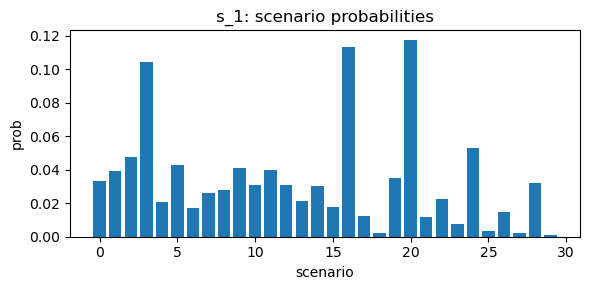

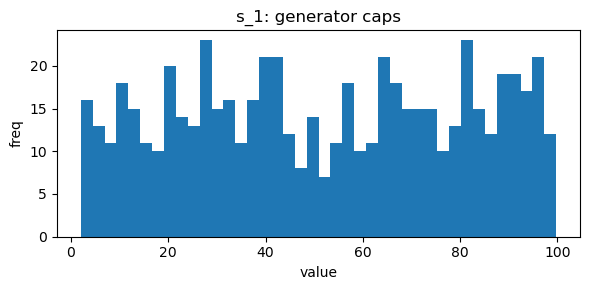

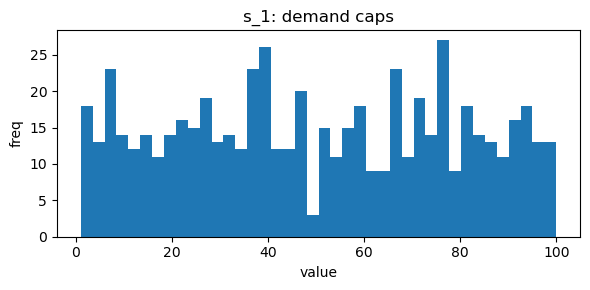

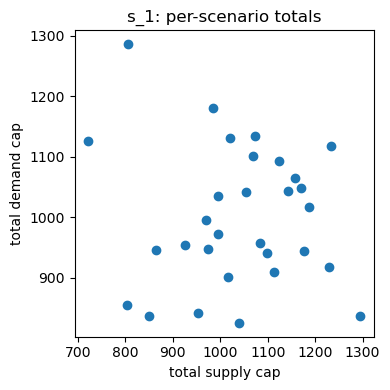

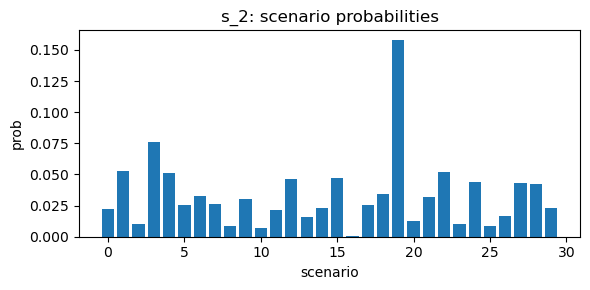

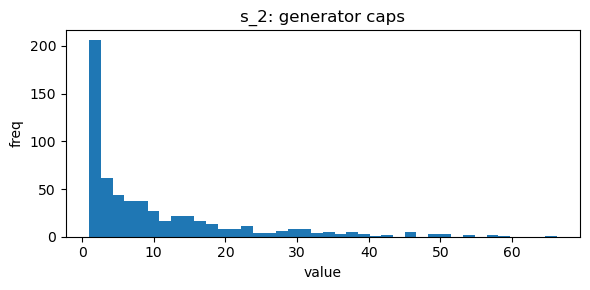

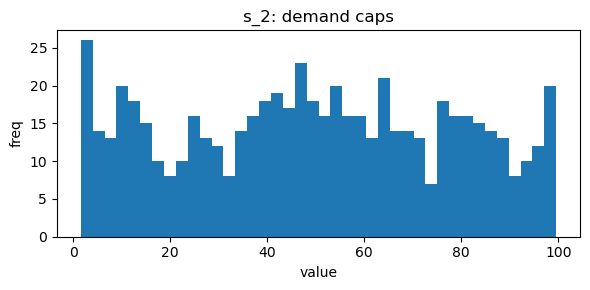

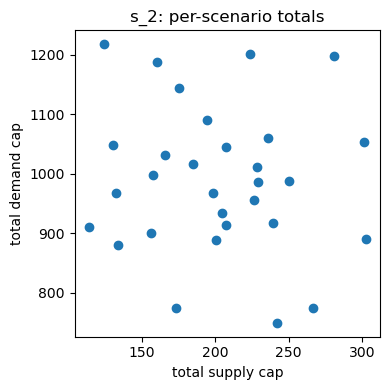

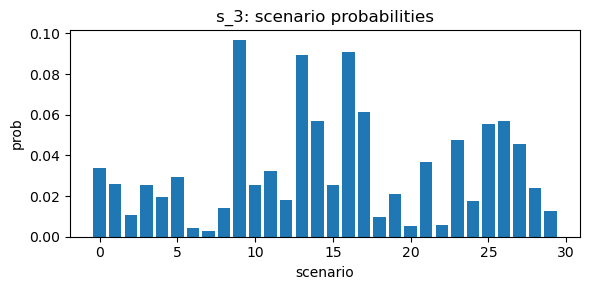

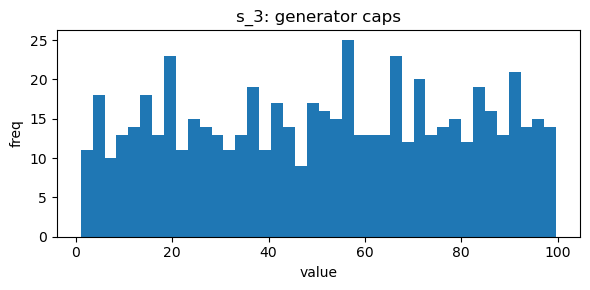

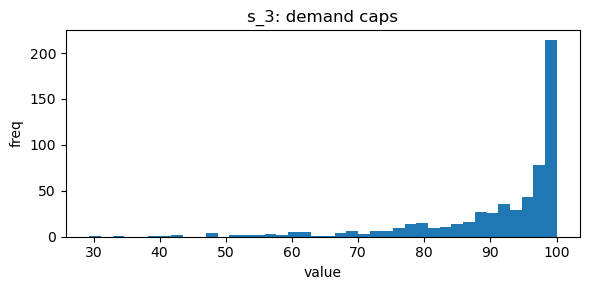

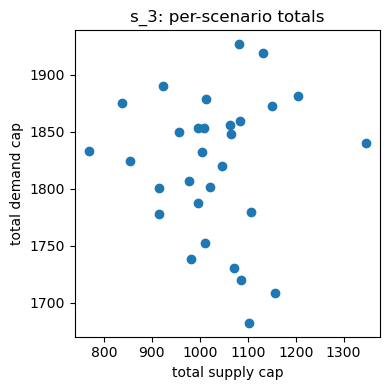

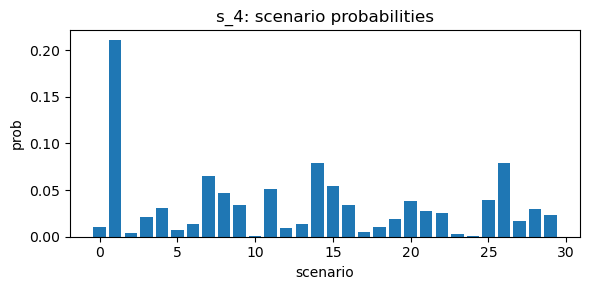

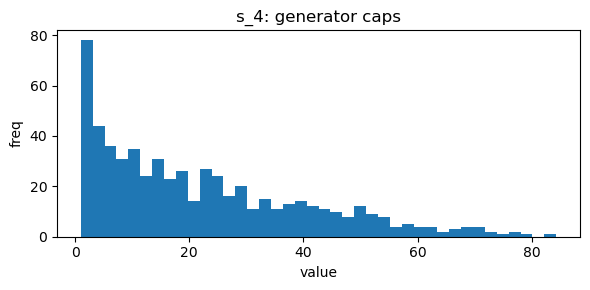

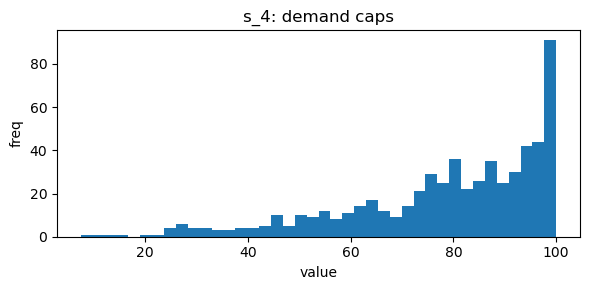

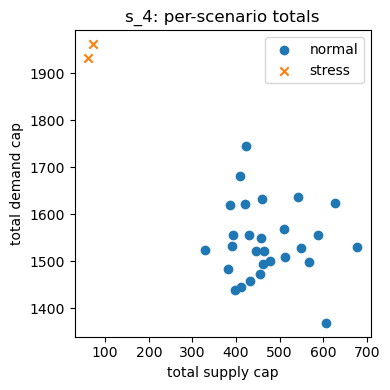

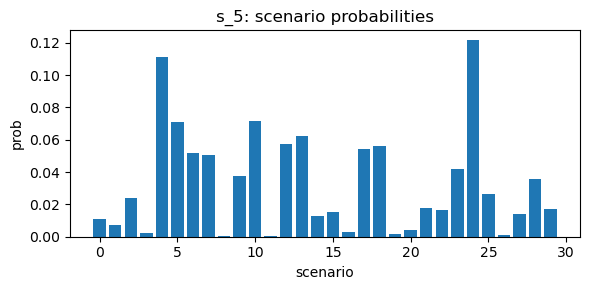

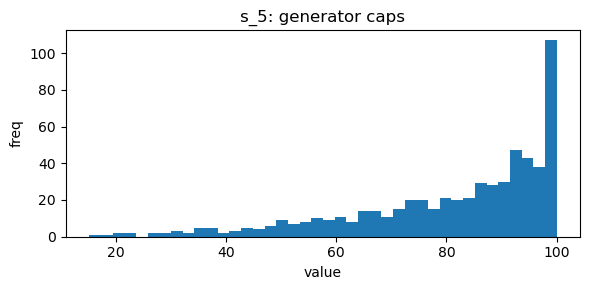

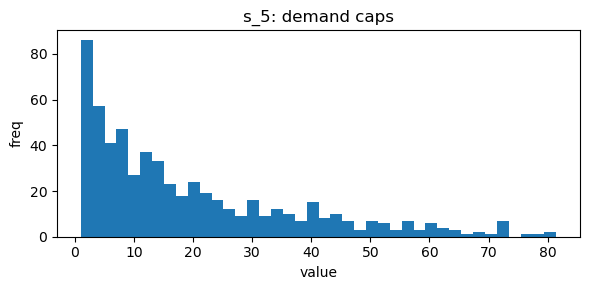

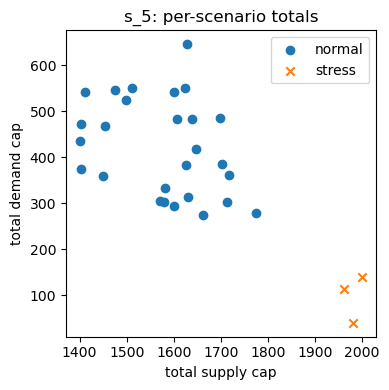

In [6]:
import numpy as np, matplotlib.pyplot as plt
from pathlib import Path

def plot_probs(probs, title, out):
    plt.figure(figsize=(6,3)); plt.bar(np.arange(len(probs)), probs); plt.title(title); plt.xlabel("scenario"); plt.ylabel("prob"); plt.tight_layout(); plt.savefig(out); plt.show()

def plot_hist(x, title, out, bins=40):
    plt.figure(figsize=(6,3)); plt.hist(x.ravel(), bins=bins); plt.title(title); plt.xlabel("value"); plt.ylabel("freq"); plt.tight_layout(); plt.savefig(out); plt.show()

def plot_supply_demand_scatter(g, d, title, out, is_tail=None):
    gsum = g.sum(1); dsum = d.sum(1)
    plt.figure(figsize=(4,4))
    if is_tail is None or is_tail.sum()==0:
        plt.scatter(gsum, dsum)
    else:
        idx0 = ~is_tail; idx1 = is_tail
        plt.scatter(gsum[idx0], dsum[idx0], label="normal")
        plt.scatter(gsum[idx1], dsum[idx1], marker="x", label="stress")
        plt.legend()
    plt.title(title); plt.xlabel("total supply cap"); plt.ylabel("total demand cap"); plt.tight_layout(); plt.savefig(out); plt.show()

def visualize_scenario(rng, scenario, S=10, G=10, D=10, lo=1.0, hi=100.0, tau=1.0, eps=0.10, outdir=Path("figures")):
    outdir.mkdir(parents=True, exist_ok=True)
    probs, mc, mv, g, d, extras = sample_instance(rng, scenario, S,G,D,lo,hi,tau,eps)
    tag = f"{scenario}_S{S}_G{G}_D{D}"
    plot_probs(probs, f"{scenario}: scenario probabilities", outdir/f"{tag}_probs.png")
    plot_hist(g, f"{scenario}: generator caps", outdir/f"{tag}_g_hist.png")
    plot_hist(d, f"{scenario}: demand caps", outdir/f"{tag}_d_hist.png")
    plot_supply_demand_scatter(g, d, f"{scenario}: per-scenario totals", outdir/f"{tag}_totals.png", extras.get("is_tail"))

if __name__=="__main__":
    rng = np.random.default_rng(123)
    scenarios = ["s_1","s_2","s_3","s_4","s_5"]
    for sc in scenarios:
        visualize_scenario(rng, sc, S=30, G=20, D=20, lo=1.0, hi=100.0, tau=1.0, eps=0.10)

Welfare Plot Distribution

In [10]:
import time
import numpy as np
from jax import random

from zavala_funcs import (
    # stochastic
    zavala,
    zavala_cvar,
    generate_instance,
    price_distortion,
    probability_feasible,
    expected_cumulative_regret,
    # deterministic bits
    zavala_deterministic_da,
    zavala_rt_energy_only,
    expected_caps_from_scenarios,
    # >>> ADDED: printing helpers
    _print_da_rt_summary,
    _stack_rt,
    compute_social_surplus)

# =========================
# Run Zavala baseline (stochastic) + deterministic + CVaR
# =========================
num_instances = 1000
key = random.key(200)
keys = random.split(key, num_instances)
instances = []
for key in keys:
    instances.append(generate_instance(key, num_scenarios=10, num_g=10, num_d=10))

# --- stochastic accumulators ---
zavala_times = []
zavala_distortions = []
zavala_regrets = []
probs_feasible = []

# --- deterministic accumulators ---
det_distortions = []
det_regrets = []

# --- CVaR accumulators ---
cvar_distortions = []
cvar_regrets = []

# --- social-surplus accumulators ---
stoch_ss_neg_total, stoch_ss_neg_supplier, stoch_ss_neg_consumer, stoch_ss = [], [], [], []
det_ss_neg_total,   det_ss_neg_supplier,   det_ss_neg_consumer,   det_ss   = [], [], [], []
cvar_ss_neg_total,  cvar_ss_neg_supplier,  cvar_ss_neg_consumer,  cvar_ss  = [], [], [], []

for i in range(len(instances)):
    probs, mc_g_i, mv_d_j, g_i_bar, d_j_bar = instances[i]

    # ===== Stochastic Zavala =====
    # >>> CHANGED: capture Z_G, Z_D instead of discarding
    z_g_i, z_d_j, Z_G, Z_D, z_pi, z_Pi = zavala(probs, mc_g_i, mv_d_j, g_i_bar, d_j_bar)

    probs_feasible.append(probability_feasible(probs, z_g_i, z_d_j, g_i_bar, d_j_bar))
    zavala_distortions.append(price_distortion(probs, z_pi, z_Pi))
    zavala_regrets.append(expected_cumulative_regret(probs, z_g_i, z_d_j, z_pi, mc_g_i, mv_d_j, g_i_bar, d_j_bar))
    ss_stoch = compute_social_surplus(
        probs, mc_g_i, mv_d_j,
        g_da=z_g_i, d_da=z_d_j,
        G_rt=Z_G, D_rt=Z_D,
        # optional: pass custom deltas to match your experiments
        # mc_g_i_delta=mc_g_i/10.0, mv_d_j_delta=mv_d_j/10.0
    )
    stoch_ss_neg_total.append(ss_stoch["E_neg_total"])
    stoch_ss_neg_supplier.append(ss_stoch["E_neg_supplier"])
    stoch_ss_neg_consumer.append(ss_stoch["E_neg_consumer"])
    stoch_ss.append(ss_stoch["E_social_surplus"])

    # ===== CVaR Zavala =====
    # >>> CHANGED: capture C_G, C_D so we can print
    cvar_g_i, cvar_d_j, C_G, C_D, cvar_pi, cvar_Pi = zavala_cvar(probs, mc_g_i, mv_d_j, g_i_bar, d_j_bar)
    cvar_distortions.append(price_distortion(probs, cvar_pi, cvar_Pi))
    cvar_regrets.append(expected_cumulative_regret(probs, cvar_g_i, cvar_d_j, cvar_pi, mc_g_i, mv_d_j, g_i_bar, d_j_bar))
    ss_cvar = compute_social_surplus(
        probs, mc_g_i, mv_d_j,
        g_da=cvar_g_i, d_da=cvar_d_j,
        G_rt=C_G, D_rt=C_D,
    )
    cvar_ss_neg_total.append(ss_cvar["E_neg_total"])
    cvar_ss_neg_supplier.append(ss_cvar["E_neg_supplier"])
    cvar_ss_neg_consumer.append(ss_cvar["E_neg_consumer"])
    cvar_ss.append(ss_cvar["E_social_surplus"])          

    # ===== Deterministic Zavala (energy-only, no network) =====
    # Use expected capacities for DA
    gbar_det, dbar_det = expected_caps_from_scenarios(probs, g_i_bar, d_j_bar)

    # Day-ahead deterministic solve
    g_det, d_det, pi_det = zavala_deterministic_da(mc_g_i, mv_d_j, gbar_det, dbar_det)

    # Real-time per scenario — also collect RT dispatch to print deltas
    G_det_list, D_det_list, Pi_det_list = [], [], []
    for p in range(len(probs)):
        Gp, Dp, Pi_p = zavala_rt_energy_only(mc_g_i, mv_d_j, g_i_bar[p], d_j_bar[p])
        G_det_list.append(Gp)
        D_det_list.append(Dp)
        Pi_det_list.append(Pi_p)
    G_det_rt, D_det_rt = _stack_rt(G_det_list, D_det_list)
    Pi_det = np.array(Pi_det_list)

    det_distortions.append(price_distortion(probs, pi_det, Pi_det))
    det_regrets.append(expected_cumulative_regret(probs, g_det, d_det, pi_det, mc_g_i, mv_d_j, g_i_bar, d_j_bar))

    # --- NEW: §4.1 social surplus for deterministic run ---
    ss_det = compute_social_surplus(
        probs, mc_g_i, mv_d_j,
        g_da=g_det, d_da=d_det,
        G_rt=G_det_rt, D_rt=D_det_rt,
        # mc_g_i_delta=mc_g_i/10.0, mv_d_j_delta=mv_d_j/10.0,  # (optional) explicitly pass deltas
    )
    det_ss_neg_total.append(ss_det["E_neg_total"])
    det_ss_neg_supplier.append(ss_det["E_neg_supplier"])
    det_ss_neg_consumer.append(ss_det["E_neg_consumer"])
    det_ss.append(ss_det["E_social_surplus"])

# # ============== Overall Expectation Results =================
# print(f'Stochastic Zavala mean distortion: {np.mean(zavala_distortions)}')
# print(f'Stochastic Zavala with CVaR mean distortion: {np.mean(cvar_distortions)}')
# print(f'Deterministic mean distortion: {np.mean(det_distortions)}')

# print(f"Stochastic mean E[-SS]: {np.mean(stoch_ss_neg_total)} "
#       f"(suppliers {np.mean(stoch_ss_neg_supplier)}, consumers {np.mean(stoch_ss_neg_consumer)})")
# print(f"Stochastic mean E[SS]:  {np.mean(stoch_ss)}")

# print(f"CVaR       mean E[-SS]: {np.mean(cvar_ss_neg_total)} "
#       f"(suppliers {np.mean(cvar_ss_neg_supplier)}, consumers {np.mean(cvar_ss_neg_consumer)})")
# print(f"CVaR       mean E[SS]:  {np.mean(cvar_ss)}")

# print(f"Deterministic mean E[-SS]: {np.mean(det_ss_neg_total)} "
#       f"(suppliers {np.mean(det_ss_neg_supplier)}, consumers {np.mean(det_ss_neg_consumer)})")
# print(f"Deterministic mean E[SS]:  {np.mean(det_ss)}")

print("Stochastic Case \n")
print(f"Total Welfare = {stoch_ss_neg_total}")
print(f"Day-ahead price = {z_pi}")
print(f"Real-time price = {z_Pi}")
print(f"Probability = {probs} \n")


print("CVaR Stochastic Case \n")
print(f"Total Welfare = {cvar_ss_neg_total}")
print(f"Day-ahead price = {cvar_pi}")
print(f"Real-time price = {cvar_Pi}")
print(f"Probability = {probs} \n")

# tail_vals_stoch, tail_probs_stoch = collect_tail_list(stoch_ss_neg_total, probs, tail=0.05)
# tail_vals_cvar,  tail_probs_cvar  = collect_tail_list(cvar_ss_neg_total,  probs, tail=0.05)
# # sanity prints
# print("All stochastic NEG-SS:", np.array(stoch_ss_neg_total))
# print("Tail 5% stochastic NEG-SS:", tail_vals_stoch)
# print("Tail 5% stochastic probs:", tail_probs_stoch, " -> sum =", tail_probs_stoch.sum())

# print("All CVaR NEG-SS:", np.array(cvar_ss_neg_total))
# print("Tail 5% CVaR NEG-SS:", tail_vals_cvar)
# print("Tail 5% CVaR probs:", tail_probs_cvar, " -> sum =", tail_probs_cvar.sum())

# print(f" Mean Stochastic Tail welfare = {np.mean(tail_vals_stoch)}")
# print(f" Mean CVaR Stochastic Tail welfare = {np.mean(tail_vals_cvar)}")



Stochastic Case 

Total Welfare = [-9390.28719164094, -11886.171447956687, -1316.7957145795147, 977.4458027264241, -6273.057654105157, -6811.245977293059, -7098.8248673669605, -7021.468336063365, -1269.0183612404137, -25.088429356693144, -4399.610149616049, -2604.397322846845, -5417.348605051297, -8378.511235581012, -1628.3439726564338, -1218.3458121884316, 1125.31802788276, -3116.878158285333, -3514.0242781488437, -1210.6305179040937, -4534.01985263817, -2819.992609536076, -6708.976790720386, -5561.13003646141, -4570.479715325951, -1989.361289383997, -4759.765679020166, -4795.7797921847805, 282.4597570776431, -4371.4067519553255, -3853.033090724681, -4142.466527883797, -2570.2597129822784, -2687.1201617539677, 1250.7158845373572, -98.54619412367434, -3908.4407457545035, -2411.3502204361253, -4118.242699964583, 682.376094020549, -2317.4972352144114, -12724.032583566153, -5868.291564716336, -6457.295586772529, -3068.9847078908033, 87.97378591169249, -5921.433392825308, -4231.42844867511

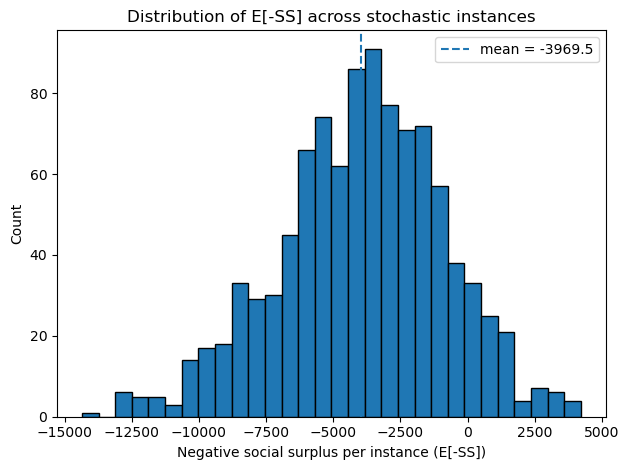

In [11]:
import matplotlib.pyplot as plt
# ---- Plot welfare distribution (negative social surplus E[-SS]) ----
vals = np.array(stoch_ss_neg_total, dtype=float)

plt.figure()
plt.hist(vals, bins=30, edgecolor='black')
plt.axvline(vals.mean(), linestyle='--', label=f"mean = {vals.mean():.1f}")
plt.xlabel("Negative social surplus per instance (E[-SS])")
plt.ylabel("Count")
plt.title("Distribution of E[-SS] across stochastic instances")
plt.legend()
plt.tight_layout()

# If you run headless or want a file, save it; otherwise plt.show() is fine.
# plt.savefig("stochastic_neg_ss_distribution.png", dpi=150)
plt.show()